In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as sps
import scipy as sp
from scipy import special
import lmfit as lm
import pymc3 as pm
import theano.tensor as tt
from theano import shared

In [2]:
def two_rates(t,k1,k2):
    if k1==k2:
        return k1**2*np.exp(-k1*t)
    else:
        return k1*k2/(k1-k2)*(np.exp(-k2*t)-np.exp(-k1*t))
    
def three_rates(t,k1,k2,k3):
    return k1*k2*k3/(k1-k2)*((np.exp(-k1*t)-np.exp(-k3*t))/(k1-k3)-(np.exp(-k2*t)-np.exp(-k3*t))/(k2-k3))

def four_rates(t,k1,k2,k3,k4):
    result=np.exp(-k2*t)/(k2-k3)/(k2-k4)
    result+=np.exp(-k3*t)*(k2-k1)/(k3-k1)/(k3-k2)/(k3-k4)
    result+=np.exp(-k1*t)/(k1-k3)/(k4-k1)
    result+=np.exp(-k4*t)*(k2-k1)/(k4-k1)/(k4-k2)/(k4-k3)
    return result*k1*k2*k3*k4/(k1-k2)

In [3]:
t_transfection = {
    "20171026_K1_gfp": 1.33,
    "20171026_K2_gfp": 1.33,
    "20171026_K3_gfp": 1.33,
    "20171026_K4_gfp": 1.33,
    "20171026_K5_gfp": 1.33,
    "20171026_K6_gfp": 1.33,
    "20170316_K1_gfp": 1,
    "20170316_K3_gfp": 1,
    "20170316_K5_gfp": 1,
    "20161006_DDC_gfp": -.3,
    "20161006_Lipo_gfp": -.3,
    "20161006_Lipo2_gfp": -.3,
}
analysis_excel = pd.read_excel("2017-11-20_onset/2017-11-20–113044_PARAMS_20171026_K1_gfp.xlsx",sheetname="par3")
analysis_excel

,t0,ktl,km,delta,beta,off
0,4.152993,5.096251e+04,0.047988,8.393200,1.668720e-05,25.830198
1,3.937851,1.253652e+06,0.016617,84.390855,1.597213e-30,26.236000
2,2.295943,4.473590e+04,0.030384,1.501297,4.635098e-38,25.363962
3,3.173050,3.790617e+03,0.044391,1.952134,3.579318e-06,25.135922
4,4.189042,8.361727e+03,0.091042,6.703152,2.804069e-03,25.164665
5,3.995671,3.038374e+03,0.046351,1.867242,2.058273e-13,25.523373
6,2.593022,5.452552e+03,0.057498,1.044021,5.135160e-02,24.470340
7,3.165533,1.614201e+04,0.025535,1.737823,4.332451e-07,24.244590
8,6.914153,6.609082e+04,0.005672,2.430741,3.463017e-36,23.447872
9,3.740247,6.847331e+04,0.013212,6.455559,2.024968e-37,25.202661


In [4]:
data = np.array(analysis_excel['t0'])-1.33
tau_mean = data.mean()
n = data.size

beta_0_list=[]
beta_0_std_list=[]

for alpha in range(1,10):
    beta_est = alpha/tau_mean
    beta_std = beta_est/np.sqrt(n*alpha)
    beta_0_list.append(beta_est)
    beta_0_std_list.append(beta_std)
beta_0_list = np.array(beta_0_list)
beta_0_std_list = np.array(beta_0_std_list)


In [5]:
# now we need to calculate the likelihood function
def gamma_like(data,alpha,beta):
    p = sps.gamma.pdf(data,alpha,scale=1/beta)
    return np.prod(p)
def gamma_like_log(data,alpha,beta):
    p = np.log(sps.gamma.pdf(data,alpha,scale=1/beta))
    return np.sum(p)

In [6]:
p_like_list=[]
for n,beta_0 in enumerate(beta_0_list):
    p_like_list.append(gamma_like(data,n+1,beta_0))
p_like_list=np.array(p_like_list)

In [7]:
print(p_like_list*beta_0_std_list)

[  1.72755787e-161   2.62711871e-139   7.73762721e-131   1.13808830e-127
   2.49359947e-127   9.50679507e-129   2.28051954e-131   7.33744734e-135
   5.13457891e-139]


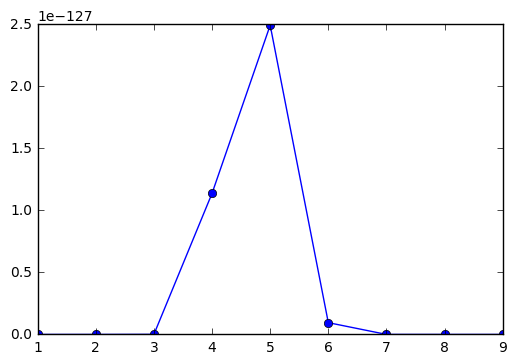

In [9]:
plt.plot(np.arange(9)+1,p_like_list*beta_0_std_list,"o-")

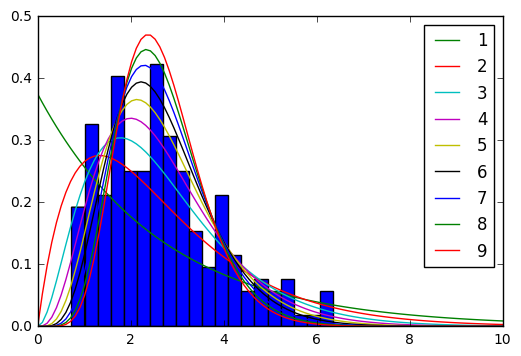

In [10]:
#plot the histogram and all the fits
x = np.linspace(0,10,100)
plt.hist(data, bins=20,normed=True)
for n,beta in enumerate(beta_0_list):
    plt.plot(x,sps.gamma.pdf(x,n+1,scale=1/beta),label=str(n+1))
    plt.legend()